<a href="https://colab.research.google.com/github/siddhantgupta21/FashionMNIST/blob/main/FashionMNIST.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import torch
from torch import nn

import torchvision
from torchvision import datasets
from torchvision import transforms
from torchvision.transforms import ToTensor

import matplotlib.pyplot as plt

print(torch.__version__)
print(torchvision.__version__)

2.3.0+cu121
0.18.0+cu121


We will be using FashionMNIST dataset from torchvision.datasets


In [2]:
from torchvision import datasets

#downloading the training data
train_data = datasets.FashionMNIST(root="data",train=True,download=True,transform=torchvision.transforms.ToTensor(),target_transform=None)

#downloading the test data
test_data = datasets.FashionMNIST(root="data",train=False,download=True,transform=torchvision.transforms.ToTensor(),target_transform=None)

len(train_data),len(test_data)

100%|██████████| 26421880/26421880 [00:03<00:00, 6905116.59it/s]


Extracting data/FashionMNIST/raw/train-images-idx3-ubyte.gz to data/FashionMNIST/raw



100%|██████████| 29515/29515 [00:00<00:00, 149712.15it/s]


Extracting data/FashionMNIST/raw/train-labels-idx1-ubyte.gz to data/FashionMNIST/raw



100%|██████████| 4422102/4422102 [00:01<00:00, 2796374.25it/s]


Extracting data/FashionMNIST/raw/t10k-images-idx3-ubyte.gz to data/FashionMNIST/raw



100%|██████████| 5148/5148 [00:00<00:00, 21788372.34it/s]

Extracting data/FashionMNIST/raw/t10k-labels-idx1-ubyte.gz to data/FashionMNIST/raw



(60000, 10000)

In [3]:
train_data.classes
class_names = train_data.classes

In [4]:
train_data.class_to_idx

{'T-shirt/top': 0,
 'Trouser': 1,
 'Pullover': 2,
 'Dress': 3,
 'Coat': 4,
 'Sandal': 5,
 'Shirt': 6,
 'Sneaker': 7,
 'Bag': 8,
 'Ankle boot': 9}

In [5]:
train_data.train_labels

/usr/local/lib/python3.10/dist-packages/torchvision/datasets/mnist.py:66: UserWarning: train_labels has been renamed targets
  warnings.warn("train_labels has been renamed targets")


tensor([9, 0, 0,  ..., 3, 0, 5])

In [6]:
#get shape of data

image , label = train_data[0]
image.shape,label

(torch.Size([1, 28, 28]), 9)

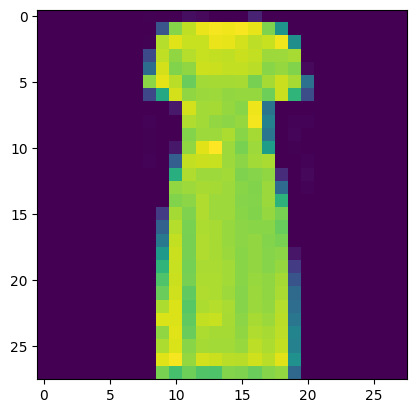

In [7]:
#visualizing data
import matplotlib.pyplot as plt
image , label = train_data[50]
plt.imshow(image.squeeze())

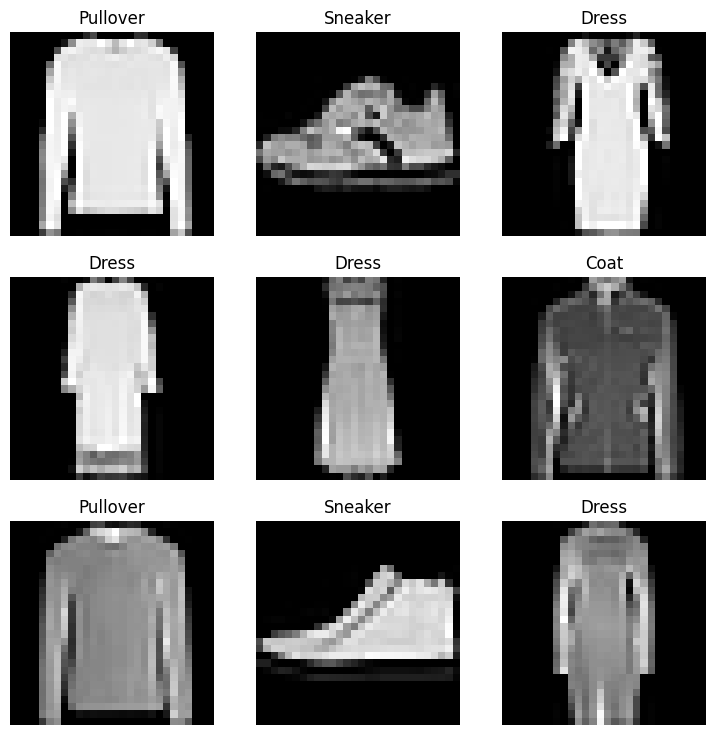

In [8]:
fig = plt.figure(figsize=(9, 9))
rows, cols = 3, 3
for i in range(1, rows*cols+1):
  random_idx = torch.randint(0, len(train_data), size=[1]).item()
  img, label = train_data[random_idx]
  fig.add_subplot(rows, cols, i)
  plt.imshow(img.squeeze(), cmap="gray")
  plt.title(class_names[label])
  plt.axis(False);

In [9]:
#prepare dataloader
from torch.utils.data import DataLoader
BATCH_SIZE=32
train_dataloader = DataLoader(dataset = train_data,batch_size=BATCH_SIZE,shuffle=True)
test_dataloader = DataLoader(dataset = test_data,batch_size=BATCH_SIZE,shuffle=True)


test_dataloader

In [10]:
len(test_dataloader),len(train_dataloader)

(313, 1875)

In [11]:
60000/32

1875.0

In [12]:
10000/32

312.5

In [13]:
train_features_batch, train_labels_batch = next(iter(train_dataloader))
train_features_batch.shape, train_labels_batch.shape


(torch.Size([32, 1, 28, 28]), torch.Size([32]))

Image size: torch.Size([1, 28, 28])
Label: 9, label size: torch.Size([])


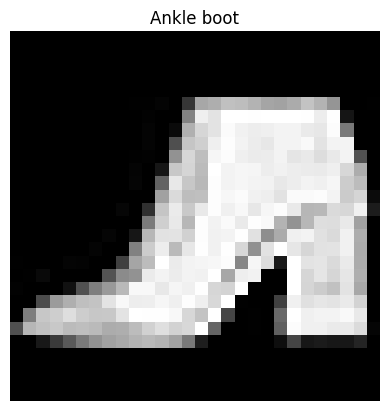

In [14]:

# Show a sample
# torch.manual_seed(42)
random_idx = torch.randint(0, len(train_features_batch), size=[1]).item()
img, label = train_features_batch[random_idx], train_labels_batch[random_idx]
plt.imshow(img.squeeze(), cmap="gray")
plt.title(class_names[label])
plt.axis(False)
print(f"Image size: {img.shape}")
print(f"Label: {label}, label size: {label.shape}")

In [15]:
#baseline model
flatten_model = nn.Flatten()
x = train_features_batch[0]
output = flatten_model(x)

x.shape, output.shape


(torch.Size([1, 28, 28]), torch.Size([1, 784]))

In [16]:
from timeit import default_timer as timer
def print_train_time(start: float,
                     end: float,
                     device: torch.device = None):
  """Prints difference between start and end time."""
  total_time = end - start
  print(f"Train time on {device}: {total_time:.3f} seconds")
  return total_time

In [17]:
# testing print_train_time

start_time = timer()
# some code...
end_time = timer()
print_train_time(start=start_time, end=end_time, device="cpu")


Train time on cpu: 0.000 seconds


7.502099998646372e-05

In [18]:
#setting up device agnostic code
import torch
device = "cuda" if torch.cuda.is_available() else "cpu"
device

'cuda'

In [19]:
def accuracy_fn(y_true, y_pred):
    """Calculates accuracy between truth labels and predictions.

    Args:
        y_true (torch.Tensor): Truth labels for predictions.
        y_pred (torch.Tensor): Predictions to be compared to predictions.

    Returns:
        [torch.float]: Accuracy value between y_true and y_pred, e.g. 78.45
    """
    correct = torch.eq(y_true, y_pred).sum().item()
    acc = (correct / len(y_pred)) * 100
    return acc


In [20]:
def train_step(model: torch.nn.Module,data_loader: torch.utils.data.DataLoader,
               loss_fn: torch.nn.Module,
               optimizer: torch.optim.Optimizer,
               accuracy_fn,
               device: torch.device = device ):
  train_loss, train_acc = 0, 0
  model.to(device)
  for batch, (X, y) in enumerate(data_loader):
        # Send data to GPU
        X, y = X.to(device), y.to(device)

        y_pred = model(X)

        loss = loss_fn(y_pred, y)
        train_loss += loss
        train_acc += accuracy_fn(y_true=y,
                                 y_pred=y_pred.argmax(dim=1))

        optimizer.zero_grad()

        loss.backward()

        optimizer.step()

  train_loss /= len(data_loader)
  train_acc /= len(data_loader)
  print(f"Train loss: {train_loss:.5f} | Train accuracy: {train_acc:.2f}%")



In [21]:
def test_step(data_loader: torch.utils.data.DataLoader,
              model: torch.nn.Module,
              loss_fn: torch.nn.Module,
              accuracy_fn,
              device: torch.device = device):
    test_loss, test_acc = 0, 0
    model.to(device)
    model.eval()
    with torch.inference_mode():
        for X, y in data_loader:
            X, y = X.to(device), y.to(device)

            test_pred = model(X)

            test_loss += loss_fn(test_pred, y)
            test_acc += accuracy_fn(y_true=y,
                y_pred=test_pred.argmax(dim=1)
            )

        test_loss /= len(data_loader)
        test_acc /= len(data_loader)
        print(f"Test loss: {test_loss:.5f} | Test accuracy: {test_acc:.2f}%\n")

In [22]:
#creating a cnn using TinyVGG architechture
class FashionMNISTModel(nn.Module):
    """
    Model architecture copying TinyVGG from:
    https://poloclub.github.io/cnn-explainer/
    """
    def __init__(self, input_shape: int, hidden_units: int, output_shape: int):
        super().__init__()
        self.block_1 = nn.Sequential(
            nn.Conv2d(in_channels=input_shape,
                      out_channels=hidden_units,
                      kernel_size=3,
                      stride=1,
                      padding=1),
            nn.ReLU(),
            nn.Conv2d(in_channels=hidden_units,
                      out_channels=hidden_units,
                      kernel_size=3,
                      stride=1,
                      padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2,
                         stride=2)
        )
        self.block_2 = nn.Sequential(
            nn.Conv2d(hidden_units, hidden_units, 3, padding=1),
            nn.ReLU(),
            nn.Conv2d(hidden_units, hidden_units, 3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2)
        )
        self.classifier = nn.Sequential(
            nn.Flatten(),
            nn.Linear(in_features=hidden_units*7*7,
                      out_features=output_shape)
        )

    def forward(self, x: torch.Tensor):
        x = self.block_1(x)
        x = self.block_2(x)
        x = self.classifier(x)
        return x

torch.manual_seed(42)
model = FashionMNISTModel(input_shape=1,
    hidden_units=10,
    output_shape=len(class_names)).to(device)
model

FashionMNISTModel(
  (block_1): Sequential(
    (0): Conv2d(1, 10, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): Conv2d(10, 10, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU()
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (block_2): Sequential(
    (0): Conv2d(10, 10, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): Conv2d(10, 10, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU()
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (classifier): Sequential(
    (0): Flatten(start_dim=1, end_dim=-1)
    (1): Linear(in_features=490, out_features=10, bias=True)
  )
)

In [23]:
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(params=model.parameters(),
                             lr=0.1)

In [24]:
torch.manual_seed(42)

from timeit import default_timer as timer
train_time_start_model = timer()

epochs = 3
for epoch in (range(epochs)):
    print(f"Epoch: {epoch}\n---------")
    train_step(data_loader=train_dataloader,
        model=model,
        loss_fn=loss_fn,
        optimizer=optimizer,
        accuracy_fn=accuracy_fn,
        device=device
    )
    test_step(data_loader=test_dataloader,
        model=model,
        loss_fn=loss_fn,
        accuracy_fn=accuracy_fn,
        device=device
    )

train_time_end_model = timer()
total_train_time_model_2 = print_train_time(start=train_time_start_model,
                                           end=train_time_end_model,
                                           device=device)

Epoch: 0
---------
Train loss: 0.59340 | Train accuracy: 78.53%
Test loss: 0.39759 | Test accuracy: 85.57%

Epoch: 1
---------
Train loss: 0.35889 | Train accuracy: 87.01%
Test loss: 0.40420 | Test accuracy: 85.67%

Epoch: 2
---------
Train loss: 0.32499 | Train accuracy: 88.32%
Test loss: 0.34957 | Test accuracy: 87.19%

Train time on cuda: 36.886 seconds


In [28]:
torch.manual_seed(42)
def eval_model(model: torch.nn.Module,
               data_loader: torch.utils.data.DataLoader,
               loss_fn: torch.nn.Module,
               accuracy_fn,
               device: torch.device = device):
    """Evaluates a given model on a given dataset.

    Args:
        model (torch.nn.Module): A PyTorch model capable of making predictions on data_loader.
        data_loader (torch.utils.data.DataLoader): The target dataset to predict on.
        loss_fn (torch.nn.Module): The loss function of model.
        accuracy_fn: An accuracy function to compare the models predictions to the truth labels.
        device (str, optional): Target device to compute on. Defaults to device.

    Returns:
        (dict): Results of model making predictions on data_loader.
    """
    loss, acc = 0, 0
    model.eval()
    with torch.inference_mode():
        for X, y in data_loader:
            # Send data to the target device
            X, y = X.to(device), y.to(device)
            y_pred = model(X)
            loss += loss_fn(y_pred, y)
            acc += accuracy_fn(y_true=y, y_pred=y_pred.argmax(dim=1))

        # Scale loss and acc
        loss /= len(data_loader)
        acc /= len(data_loader)
    return {"model_name": model.__class__.__name__, # only works when model was created with a class
            "model_loss": loss.item(),
            "model_acc": acc}

In [29]:
model_results = eval_model(
    model=model,
    data_loader=test_dataloader,
    loss_fn=loss_fn,
    accuracy_fn=accuracy_fn,
    device=device
)
model_results

{'model_name': 'FashionMNISTModel',
 'model_loss': 0.34900856018066406,
 'model_acc': 87.22044728434504}

In [30]:
torch.manual_seed(42)

from timeit import default_timer as timer
train_time_start_model = timer()

epochs = 100
for epoch in (range(epochs)):
    print(f"Epoch: {epoch}\n---------")
    train_step(data_loader=train_dataloader,
        model=model,
        loss_fn=loss_fn,
        optimizer=optimizer,
        accuracy_fn=accuracy_fn,
        device=device
    )
    test_step(data_loader=test_dataloader,
        model=model,
        loss_fn=loss_fn,
        accuracy_fn=accuracy_fn,
        device=device
    )

train_time_end_model = timer()
total_train_time_model_2 = print_train_time(start=train_time_start_model,
                                           end=train_time_end_model,
                                           device=device)

Epoch: 0
---------
Train loss: 0.30598 | Train accuracy: 88.99%
Test loss: 0.32321 | Test accuracy: 88.17%

Epoch: 1
---------
Train loss: 0.29284 | Train accuracy: 89.31%
Test loss: 0.34827 | Test accuracy: 87.39%

Epoch: 2
---------
Train loss: 0.28103 | Train accuracy: 89.88%
Test loss: 0.32898 | Test accuracy: 88.24%

Epoch: 3
---------
Train loss: 0.27590 | Train accuracy: 89.94%
Test loss: 0.29817 | Test accuracy: 89.01%

Epoch: 4
---------
Train loss: 0.26910 | Train accuracy: 90.25%
Test loss: 0.29075 | Test accuracy: 89.12%

Epoch: 5
---------
Train loss: 0.26268 | Train accuracy: 90.46%
Test loss: 0.29492 | Test accuracy: 89.50%

Epoch: 6
---------
Train loss: 0.25837 | Train accuracy: 90.56%
Test loss: 0.29720 | Test accuracy: 89.70%

Epoch: 7
---------
Train loss: 0.25367 | Train accuracy: 90.69%
Test loss: 0.30963 | Test accuracy: 88.84%

Epoch: 8
---------
Train loss: 0.25002 | Train accuracy: 90.83%
Test loss: 0.30725 | Test accuracy: 88.87%

Epoch: 9
---------
Train los

KeyboardInterrupt: 

In [31]:
model_results2 = eval_model(
    model=model,
    data_loader=test_dataloader,
    loss_fn=loss_fn,
    accuracy_fn=accuracy_fn,
    device=device
)
model_results2

{'model_name': 'FashionMNISTModel',
 'model_loss': 0.2987709641456604,
 'model_acc': 89.91613418530352}

In [33]:
from pathlib import Path

# Create models directory (if it doesn't already exist), see: https://docs.python.org/3/library/pathlib.html#pathlib.Path.mkdir
MODEL_PATH = Path("models")
MODEL_PATH.mkdir(parents=True, # create parent directories if needed
                 exist_ok=True # if models directory already exists, don't error
)

# Create model save path
MODEL_NAME = "pytorch_fashionMNIST_model_2.pth"
MODEL_SAVE_PATH = MODEL_PATH / MODEL_NAME

# Save the model state dict
print(f"Saving model to: {MODEL_SAVE_PATH}")
torch.save(obj=model.state_dict(), # only saving the state_dict() only saves the learned parameters
           f=MODEL_SAVE_PATH)

Saving model to: models/pytorch_fashionMNIST_model_2.pth


In [46]:
loaded_model = FashionMNISTModel(input_shape=1,
                                    hidden_units=10, # try changing this to 128 and seeing what happens
                                    output_shape=10)

# Load in the saved state_dict()
loaded_model.load_state_dict(torch.load(f=MODEL_SAVE_PATH))

# Send model to GPU
loaded_model = loaded_model.to(device)

In [49]:
def make_predictions(model: torch.nn.Module, data: list, device: torch.device = device):
    pred_probs = []
    model.eval()
    with torch.inference_mode():
        for sample in data:
            # Prepare sample
            sample = torch.unsqueeze(sample, dim=0).to(device) # Add an extra dimension and send sample to device

            # Forward pass (model outputs raw logit)
            pred_logit = model(sample)

            # Get prediction probability (logit -> prediction probability)
            pred_prob = torch.softmax(pred_logit.squeeze(), dim=0) # note: perform softmax on the "logits" dimension, not "batch" dimension (in this case we have a batch size of 1, so can perform on dim=0)

            # Get pred_prob off GPU for further calculations
            pred_probs.append(pred_prob.cpu())

    # Stack the pred_probs to turn list into a tensor
    return torch.stack(pred_probs)

In [57]:
import random
random.seed(42)
test_samples = []
test_labels = []
for sample, label in random.sample(list(test_data), k=9):
    test_samples.append(sample)
    test_labels.append(label)

# View the first test sample shape and label
print(f"Test sample image shape: {test_samples[0].shape}\nTest sample label: {test_labels[0]} ({class_names[test_labels[0]]})")

Test sample image shape: torch.Size([1, 28, 28])
Test sample label: 5 (Sandal)


In [51]:
# Make predictions on test samples with model 2
pred_probs= make_predictions(model=loaded_model,
                             data=test_samples)

# View first two prediction probabilities list
pred_probs[:2]

tensor([[3.9209e-13, 1.4470e-13, 2.1579e-12, 2.3332e-15, 7.7322e-16, 1.0000e+00,
         9.7031e-15, 1.2473e-08, 8.2981e-12, 2.6703e-08],
        [4.2475e-03, 9.9134e-01, 2.8438e-04, 8.0343e-05, 3.6449e-03, 1.9958e-09,
         4.0484e-04, 1.8848e-09, 4.0114e-07, 6.1640e-10]])

In [58]:
pred_classes = pred_probs.argmax(dim=1)
pred_classes

tensor([5, 1, 7, 4, 3, 0, 4, 7, 1])

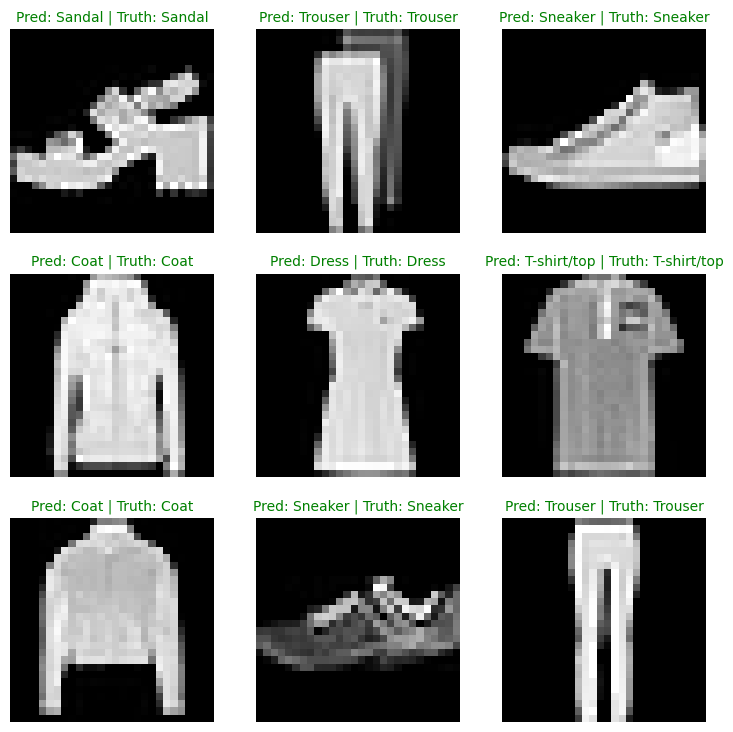

In [59]:
plt.figure(figsize=(9, 9))
nrows = 3
ncols = 3
for i, sample in enumerate(test_samples):
  # Create a subplot
  plt.subplot(nrows, ncols, i+1)

  # Plot the target image
  plt.imshow(sample.squeeze(), cmap="gray")

  # Find the prediction label (in text form, e.g. "Sandal")
  pred_label = class_names[pred_classes[i]]

  # Get the truth label (in text form, e.g. "T-shirt")
  truth_label = class_names[test_labels[i]]

  # Create the title text of the plot
  title_text = f"Pred: {pred_label} | Truth: {truth_label}"

  # Check for equality and change title colour accordingly
  if pred_label == truth_label:
      plt.title(title_text, fontsize=10, c="g") # green text if correct
  else:
      plt.title(title_text, fontsize=10, c="r") # red text if wrong
  plt.axis(False);